In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchmetrics.functional import accuracy

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
torch.__version__, pl.__version__

('1.13.0+cu116', '1.7.7')

## XOR

In [3]:
xor_inputs = [Variable(torch.Tensor([0, 0])), 
            Variable(torch.Tensor([0, 1])), 
            Variable(torch.Tensor([1, 0])), 
            Variable(torch.Tensor([1, 1]))]

In [4]:
xor_targets = [Variable(torch.Tensor([0])), 
            Variable(torch.Tensor([1])), 
            Variable(torch.Tensor([1])), 
            Variable(torch.Tensor([0]))]

In [5]:
xor_data = list(zip(xor_inputs, xor_targets))
train_loader = DataLoader(xor_data, batch_size=1000)

In [6]:
class XORModel(pl.LightningModule):
    def __init__(self) -> None:
        super(XORModel, self).__init__()
        self.input_layer = nn.Linear(2,4)
        self.output_layer = nn.Linear(4,1)
        self.sigmoid = nn.Sigmoid()
        self.loss = nn.MSELoss()

    def forward(self, input):
        x = self.input_layer(input)
        x = self.sigmoid(x)
        output = self.output_layer(x)
        return output
    
    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr=0.01)
        return optimizer

    def training_step(self, batch, batch_idx):
        xor_input, xor_target = batch
        outputs = self(xor_input) 
        loss = self.loss(outputs, xor_target)
        return loss         

In [7]:
checkpoint_callback = ModelCheckpoint()
model = XORModel()
trainer = pl.Trainer(callbacks=[checkpoint_callback], accelerator='gpu', devices=1, )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(model, train_dataloaders=train_loader)

c:\Users\sigma\works\practice-torch\venv\lib\site-packages\pytorch_lightning\loops\utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type    | Params
-----------------------------------------
0 | input_layer  | Linear  | 12    
1 | output_layer | Linear  | 5     
2 | sigmoid      | Sigmoid | 0     
3 | loss         | MSELoss | 0     
-----------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)
c:\Users\sigma\works\practice-torch\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number 

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [9]:
print(checkpoint_callback.best_model_path)

c:\Users\sigma\works\practice-torch\notes\lightning_logs\version_2\checkpoints\epoch=999-step=1000.ckpt


In [10]:
train_model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
test = torch.utils.data.DataLoader(xor_inputs, batch_size=1)
for val in xor_inputs:
  _ = train_model(val)
  print([int(val[0]),int(val[1])], int(_.round()))

[0, 0] 0
[0, 1] 1
[1, 0] 1
[1, 1] 0


In [11]:
train_model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
total_accuracy = []
for xor_input, xor_target in train_loader:
  for i in range(100):
    output_tensor = train_model(xor_input)
    test_accuracy = accuracy(output_tensor, xor_target.int())
    total_accuracy.append(test_accuracy)
total_accuracy = torch.mean(torch.stack(total_accuracy))
print("TOTAL ACCURACY FOR 100 ITERATIONS: ", total_accuracy.item())

TOTAL ACCURACY FOR 100 ITERATIONS:  1.0


## CNN

In [12]:
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import pandas as pd

from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import pytorch_lightning as pl
import torch
import torchvision.transforms as T

In [13]:
pd.__version__, np.__version__, torch.__version__, pl.__version__

('1.5.1', '1.23.4', '1.13.0+cu116', '1.7.7')

In [14]:
# 1. befor Kaggle API Settings
# 2. 'https://github.com/JovianML/opendatasets'
# import opendatasets as od
# dataset_url = 'https://www.kaggle.com/c/histopathologic-cancer-detection'
# od.download(dataset_url)

In [15]:
# Download 'https://www.kaggle.com/competitions/histopathologic-cancer-detection/'
cancer_labels = pd.read_csv('../datasets/histopathologic-cancer-detection/train_labels.csv')
cancer_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [16]:
cancer_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [17]:
print('No. of images in training dataset: ', len(os.listdir("../datasets/histopathologic-cancer-detection/train")))
print('No. of images in testing dataset: ', len(os.listdir("../datasets/histopathologic-cancer-detection/test")))

No. of images in training dataset:  220025
No. of images in testing dataset:  57458


In [18]:
np.random.seed(42)
train_imgs_orig = os.listdir("../datasets/histopathologic-cancer-detection/train")
selected_image_list = []
for img in np.random.choice(train_imgs_orig, 10000):
    selected_image_list.append(img)
len(selected_image_list)

10000

In [19]:
selected_image_list[0]

'8e1481f853900e17ec7c3447702175fc140a3c3c.tif'

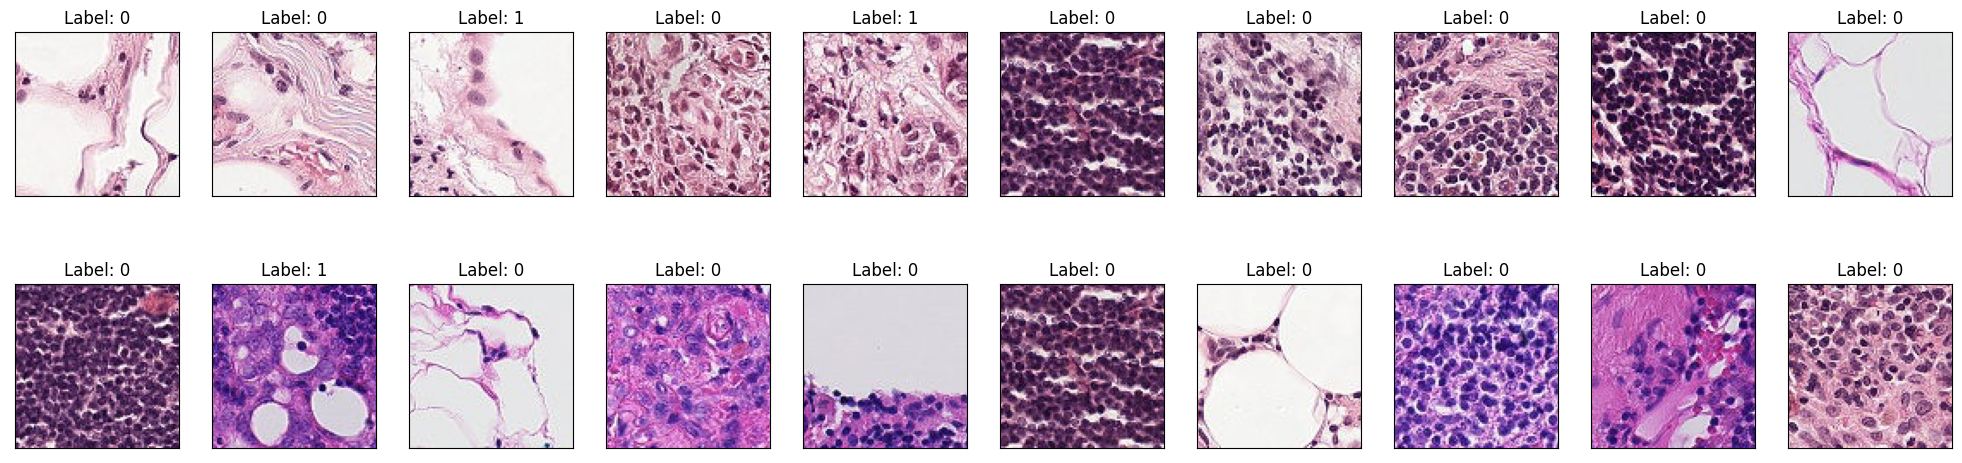

In [20]:
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(selected_image_list, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("../datasets/histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [21]:
np.random.seed(42)
np.random.shuffle(selected_image_list)
cancer_train_idx = selected_image_list[:8000]
cancer_test_idx = selected_image_list[8000:]
print("Number of images in the downsampled training dataset: ", len(cancer_train_idx))
print("Number of images in the downsampled testing dataset: ", len(cancer_test_idx))

Number of images in the downsampled training dataset:  8000
Number of images in the downsampled testing dataset:  2000


In [22]:
# os.mkdir('../datasets/histopathologic-cancer-detection/train_dataset/')
# for fname in cancer_train_idx:
#   src = os.path.join('../datasets/histopathologic-cancer-detection/train', fname)
#   dst = os.path.join('../datasets/histopathologic-cancer-detection/train_dataset/', fname)
#   shutil.copyfile(src, dst)
# print('No. of images in downsampled training dataset: ', len(os.listdir("../datasets/histopathologic-cancer-detection/train_dataset/")))

In [23]:
# os.mkdir('../datasets/histopathologic-cancer-detection/test_dataset/')
# for fname in cancer_test_idx:
#   src = os.path.join('../datasets/histopathologic-cancer-detection/train', fname)
#   dst = os.path.join('../datasets/histopathologic-cancer-detection/test_dataset/', fname)
#   shutil.copyfile(src, dst)
# print('No. of images in downsampled testing dataset: ', len(os.listdir("../datasets/histopathologic-cancer-detection/test_dataset/")))

In [24]:
data_T_train = T.Compose([
    T.CenterCrop(32),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    ])
data_T_test = T.Compose([
    T.CenterCrop(32),
    T.ToTensor(),
    ])

In [25]:
selected_image_labels = pd.DataFrame()
id_list = []
label_list = []

for img in selected_image_list:
    label_tuple = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0]]
    id_list.append(label_tuple['id'].values[0])
    label_list.append(label_tuple['label'].values[0])

In [26]:
selected_image_labels['id'] = id_list
selected_image_labels['label'] = label_list
selected_image_labels.head()

,id,label
0,bd6476113002eef43d362c8fbee5d231ec871c62,0
1,59110bc6e710571eb6754e6838e1be13128af670,1
2,5246d820f9fffa3c6f2275b46de3a1fd0ca330e9,1
3,ae6ffbbb344ff7d9e07c16d602fb08ddaf93dda4,1
4,3f7191245495d3d0961d59ba7a8ff8f355b2ff9e,0


In [27]:
img_label_dict = {k:v for k, v in zip(selected_image_labels.id, selected_image_labels.label)}

In [28]:
class LoadCancerDataset(Dataset):
    def __init__(self, data_folder, 
                 transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), dict_labels={}):
        self.data_folder = data_folder
        self.list_image_files = [s for s in os.listdir(data_folder)]
        self.transform = transform
        self.dict_labels = dict_labels
        self.labels = [dict_labels[i.split('.')[0]] for i in self.list_image_files]

    def __len__(self):
        return len(self.list_image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.list_image_files[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.list_image_files[idx].split('.')[0]

        label = self.dict_labels[img_name_short]
        return image, label

In [29]:
%%time
train_set = LoadCancerDataset(data_folder='../datasets/histopathologic-cancer-detection/train_dataset/', transform=data_T_train, dict_labels=img_label_dict)

CPU times: total: 0 ns
Wall time: 20.8 ms


In [30]:
test_set = LoadCancerDataset(data_folder='../datasets/histopathologic-cancer-detection/test_dataset/', transform=data_T_test, dict_labels=img_label_dict)

In [31]:
batch_size = 256
train_dataloader = DataLoader(train_set, batch_size, num_workers=2, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size, num_workers=2, pin_memory=True)

In [32]:
class CNNImageClassifier(pl.LightningModule):
    def __init__(self, learning_rate = 0.001):
        super().__init__()
        self.learning_rate = learning_rate
        self.conv_layer1 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv_layer2 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.fully_connected_1 =nn.Linear(in_features=16 * 16 * 6,out_features=1000)
        self.fully_connected_2 =nn.Linear(in_features=1000,out_features=500)
        self.fully_connected_3 =nn.Linear(in_features=500,out_features=250)
        self.fully_connected_4 =nn.Linear(in_features=250,out_features=120)
        self.fully_connected_5 =nn.Linear(in_features=120,out_features=60)
        self.fully_connected_6 =nn.Linear(in_features=60,out_features=2)
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters()

    def forward(self, input):
        output=self.conv_layer1(input)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv_layer2(output)
        output=self.relu2(output)
        output=output.view(-1, 6*16*16)
        output = self.fully_connected_1(output)
        output = self.fully_connected_2(output)
        output = self.fully_connected_3(output)
        output = self.fully_connected_4(output)
        output = self.fully_connected_5(output)
        output = self.fully_connected_6(output)
        return output

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs) 
        train_accuracy = accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('train_accuracy', train_accuracy, prog_bar=True)
        self.log('train_loss', loss)
        return {"loss":loss, "train_accuracy":train_accuracy}

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        test_accuracy = accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('test_accuracy', test_accuracy)
        return {"test_loss":loss, "test_accuracy":test_accuracy}

    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr = self.learning_rate)
        return optimizer

    def binary_accuracy(self, outputs, targets):
        _, outputs = torch.max(outputs,1)
        correct_results_sum = (outputs == targets).sum().float()
        acc = correct_results_sum/targets.shape[0]
        return acc

    def predict_step(self, batch, batch_idx ):
        return self(batch)

In [33]:
model = CNNImageClassifier()
trainer = pl.Trainer(accelerator='gpu', devices=1)
trainer.fit(model, train_dataloaders=train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\sigma\works\practice-torch\venv\lib\site-packages\pytorch_lightning\loops\utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name              | Type             | Params
--------------------------------------------------------
0  | conv_layer1       | Conv2d           | 84    
1  | relu1             | ReLU             | 0     
2  | pool              | MaxPool2d        | 0     
3  | conv_layer2       | Conv2d           | 168   
4  | relu2             | ReLU             | 0     
5  | fully_connected_1 | Linear           | 1.5 M 
6  | fully_connected_2 | Linear           | 500 K 
7  | fully_connected_3 | Linear           | 125 K 
8  | fully_connected_4 | Linear           |

Training: 0it [00:00, ?it/s]

In [ ]:
trainer.test(test_dataloaders=test_dataloader)

In [ ]:
model.eval()
preds = []
for batch_i, (data, target) in enumerate(test_dataloader):
    data, target = data.cuda(), target.cuda()
    output = model.cuda()(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [ ]:
test_preds = pd.DataFrame({'imgs': test_set.list_image_files, 'labels':test_set.labels,  'preds': preds})

In [ ]:
test_preds['imgs'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])

In [ ]:
test_preds.head()

In [ ]:
test_preds['predictions'] = 1
test_preds.loc[test_preds['preds'] < 0, 'predictions'] = 0
test_preds.shape

In [ ]:
test_preds.head()

In [ ]:
len(np.where(test_preds['labels'] == test_preds['predictions'])[0])/test_preds.shape[0]